In [1]:
import numpy as np

import utils.network as network
import utils.lstm_model as lstm_model
import utils.model_trainer as model_trainer
import utils.data_processer as data_processer_functions

import torch
import torch.nn as nn

from importlib import reload

# Define Network

### Network Level Parameters

In [2]:
num_nodes = 5
num_edges = 5

adjacency_nodexedge = np.zeros([num_nodes, num_edges]) # node x edge adjacency matrix of the network (with all tunnels)
adjacency_nodexedge = np.array([[-1,0,0,0,0], # -1 => node is edge's source
                                [1,-1,-1,0,0], # 1 => node is edge's destination
                                [0,1,0,-1,0],
                                [0,0,1,1,-1],
                                [0,0,0,0,1]])

### Tunnel Level Parameters

In [3]:
num_tunnels = 2

is_edge_in_tunnel      = np.zeros([num_tunnels, num_edges, ])
external_arrival_rates = np.zeros([num_tunnels, num_nodes, ])
overlay_service_rates  = np.zeros([num_tunnels, num_edges, ])
underlay_service_rates = np.zeros([num_tunnels, num_edges, ])

# tunnel 0
is_edge_in_tunnel[0,:]      = np.array([1,1,0,1,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[0,:] = np.array([0.9,0,0,0,0])
overlay_service_rates[0,:]  = np.array([1,0,0,0,0])
underlay_service_rates[0,:] = np.array([0,1,0,1,1])

# tunnel 1
is_edge_in_tunnel[1,:]      = np.array([1,0,1,0,1]) # 1 => edge is a part of the tunnel, 0 => otherwise
external_arrival_rates[1,:] = np.array([0.9,0,0,0,0])
overlay_service_rates[1,:]  = np.array([1,0,0,0,0])
underlay_service_rates[1,:] = np.array([0,0,1,0,1])

### Get Network Class

In [4]:
reload(network)
my_network = network.Network(
    num_tunnels,
    num_nodes,
    num_edges,
    adjacency_nodexedge,
    is_edge_in_tunnel, 
    underlay_service_rates,
    external_arrival_rates)

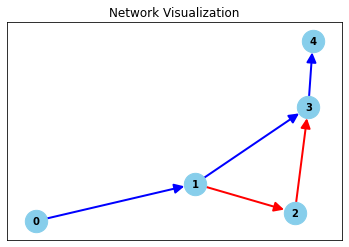

In [5]:
my_network.visualize(custom_seed = 1)

# Simulate Network

In [6]:
packets_in_flight, tunnel_backlogs = my_network.simulate(overlay_service_rates, total_time = 100000, custom_seed = 5)

# Prepare Data

In [7]:
reload(data_processer_functions)
data_processer = data_processer_functions.DataProcessor()

look_back = 5
x_all = data_processer.create_sequences(torch.Tensor(packets_in_flight), look_back)
y_all = torch.Tensor(tunnel_backlogs)

x_train_unscaled, y_train_unscaled, x_test_unscaled, y_test_unscaled = data_processer.split_train_test(x_all, y_all)

x_train, y_train = data_processer.scale_train(x_train_unscaled, y_train_unscaled, is_x_sequenced = True)
x_test, y_test = data_processer.scale_test(x_test_unscaled, y_test_unscaled)

# Model Definition

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(0)
torch.manual_seed(0)

input_size  = x_train.shape[-1]
hidden_size = 5
output_size = y_train.shape[-1]

reload(lstm_model)
lstm_predictor = lstm_model.LSTMModel(input_size, hidden_size, output_size)

In [9]:
reload(model_trainer)
trainer = model_trainer.modelTrainer(criterion = nn.MSELoss(), device = device)
optimizer = torch.optim.Adam(lstm_predictor.parameters(), lr=5e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    loss_value = trainer.batch_step(lstm_predictor, x_train, y_train, optimizer)

    # Print the loss for every few epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss_value:.4f}')

Epoch [10/100], Loss: 0.0237
Epoch [20/100], Loss: 0.0210
Epoch [30/100], Loss: 0.0154
Epoch [40/100], Loss: 0.0075
Epoch [50/100], Loss: 0.0030
Epoch [60/100], Loss: 0.0025
Epoch [70/100], Loss: 0.0021
Epoch [80/100], Loss: 0.0020
Epoch [90/100], Loss: 0.0020
Epoch [100/100], Loss: 0.0019


# Model Performance

In [10]:
def print_performance(Y, Y_predicted):
    print('RMS error = ', np.sqrt(np.mean((Y_predicted-Y)**2)))
    print('Relative error = ', 100*np.mean(np.abs(Y_predicted-Y)[Y>0]/Y[Y>0]), '%')

In [11]:
y_pred_train = lstm_predictor.evaluate(x_train)
_, y_pred_unscaled_train = data_processer.inverse_scale(0, y_pred_train)
print_performance(y_train_unscaled.numpy(), y_pred_unscaled_train.numpy())

RMS error =  6.973961
Relative error =  10.171540826559067 %


In [12]:
y_pred = lstm_predictor.evaluate(x_test)
_, y_pred_unscaled = data_processer.inverse_scale(0, y_pred)
print_performance(y_test_unscaled.numpy(), y_pred_unscaled.numpy())

RMS error =  6.6215916
Relative error =  10.325825214385986 %
